Demo: generate embedding for 10 different text snippets, compare cosine similarity.

In [5]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# 1. Load the model
model = SentenceTransformer('all-MiniLM-L6-v2')

sentences = [
    "The prime minister of India is Narendra Modi.",
    "The prime minister of USA is Donald Trump.",
    "What is the role of Database engineer in a IT company?",
    "What makes PostgreSQL an ideal software for production database storage?",
    "The sun rises in the east and sets in the west",
    "Johnny left the company on Wednesday.",
    "The event is going to be live in a few hours!",
    "The geopolitical situation of Russia and Ukraine is tough",
    "All roads lead to Rome",
    "The British east India company was established in 31 December 1600",
]

embeddings_demo = model.encode(sentences)

sim_matrix = cosine_similarity(embeddings_demo)

# Display results cleanly using a DataFrame
df_sim = pd.DataFrame(sim_matrix, columns=range(1, 11), index=range(1, 11))
print("Cosine Similarity Matrix (10x10):")
print(df_sim.round(3))

Cosine Similarity Matrix (10x10):
       1      2      3      4      5      6      7      8      9      10
1   1.000  0.587  0.137 -0.069  0.067  0.028  0.079  0.037  0.073  0.142
2   0.587  1.000  0.052 -0.091  0.049  0.033  0.051  0.146  0.054 -0.051
3   0.137  0.052  1.000  0.375  0.072  0.126 -0.034  0.078 -0.035  0.166
4  -0.069 -0.091  0.375  1.000  0.037 -0.021 -0.018  0.037 -0.066 -0.007
5   0.067  0.049  0.072  0.037  1.000 -0.060  0.120  0.130  0.130  0.178
6   0.028  0.033  0.126 -0.021 -0.060  1.000  0.129 -0.112 -0.043  0.032
7   0.079  0.051 -0.034 -0.018  0.120  0.129  1.000  0.097  0.037 -0.036
8   0.037  0.146  0.078  0.037  0.130 -0.112  0.097  1.000  0.027 -0.017
9   0.073  0.054 -0.035 -0.066  0.130 -0.043  0.037  0.027  1.000  0.036
10  0.142 -0.051  0.166 -0.007  0.178  0.032 -0.036 -0.017  0.036  1.000


Dimensionality reduction is a powerful tool for machine learning practitioners to visualize and understand large, high dimensional datasets. One of the most widely used techniques for visualization is t-SNE, but its performance suffers with large datasets and using it correctly can be challenging.

Assignment: Create embedding for a sample doc corpus and visualize clusters using UMAP/t-SNE (code provided; explain shapes, clusters).​

In [ ]:
!pip install langchain langchain-community pypdf langchain-text-splitters langchain-chroma langchain-huggingface sentence-transformers umap-learn scikit-learn matplotlib seaborn

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
from langchain_community.document_loaders import PyPDFLoader

loader=PyPDFLoader("/content/drive/MyDrive/content/user_manual.pdf")
pages = loader.load()
text_content = "\n".join([page.page_content for page in pages])

In [33]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,          # Max size of each chunk (in characters)
    chunk_overlap=200,        # Number of characters to overlap between chunks
    length_function=len,      # Use Python's len() to measure length
)

chunks = text_splitter.split_documents(pages)


In [34]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
import os

# Initialize the Local Hugging Face Embedding Model
model_name = "sentence-transformers/all-MiniLM-L6-v2"
model_kwargs = {'device': 'cpu'} # Change to 'cuda' if you have a GPU
encode_kwargs = {'normalize_embeddings': False}

embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

# Create the Vector Database
vector_db = Chroma.from_documents(
    documents=chunks,
    embedding=embeddings,
    persist_directory="./cannon_manual_db"
)

print(f"Vector database created locally using {model_name}!")

Vector database created locally using sentence-transformers/all-MiniLM-L6-v2!


Necessary imports

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

Data extraction

In [51]:
data = vector_db.get(include=['embeddings', 'documents'])
vectors = np.array(data['embeddings'])
documents = data['documents']

Re-run clustering on user manual PDF

In [52]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(vectors)

Create Figure

<Figure size 1800x700 with 0 Axes>

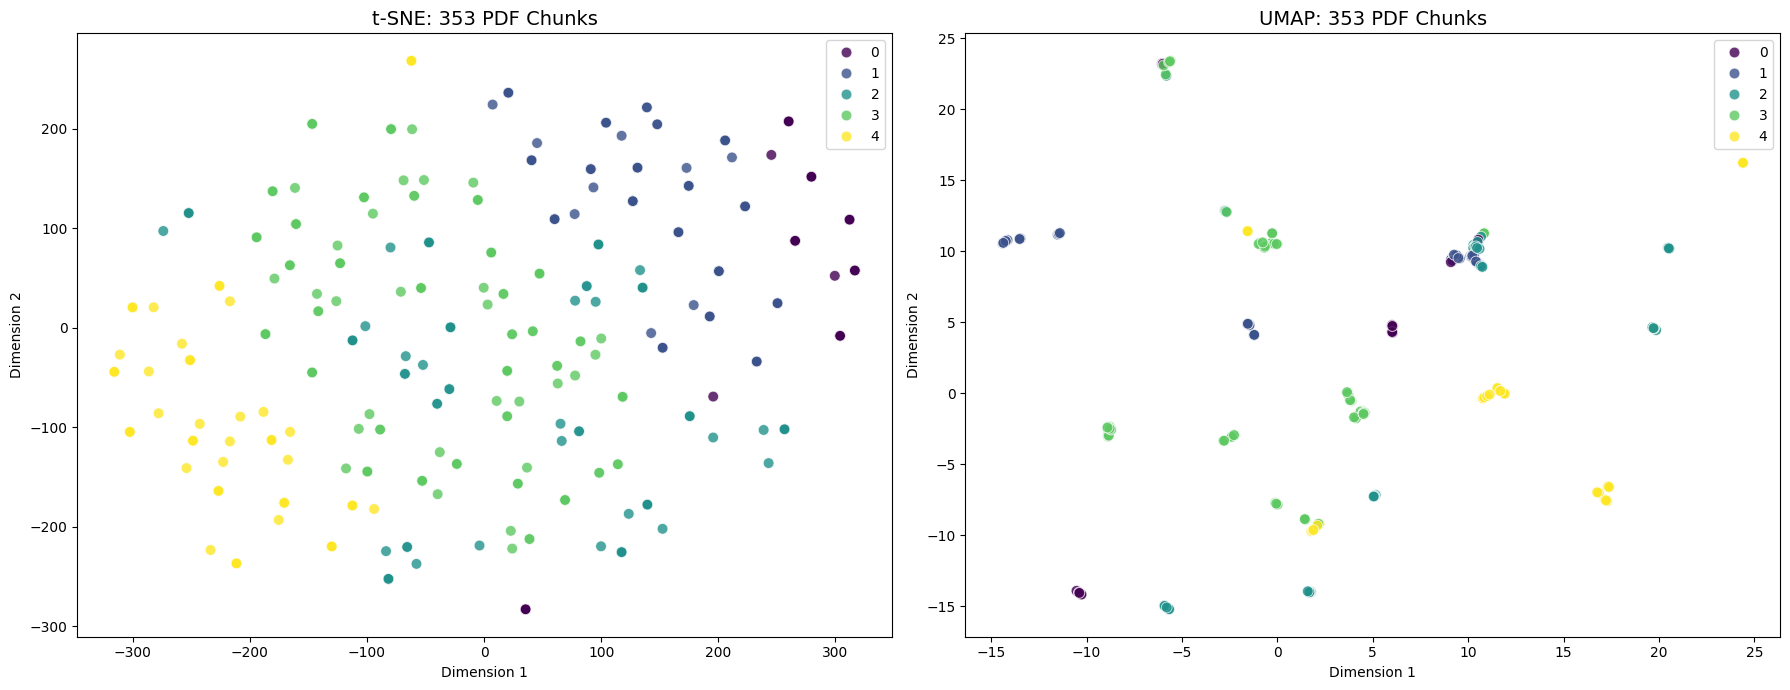

In [53]:
plt.figure(figsize=(18, 7))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: t-SNE
sns.scatterplot(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    hue=cluster_labels,
    palette='viridis',
    ax=ax1,
    s=60,
    alpha=0.8,
    legend='full'
)
ax1.set_title(f't-SNE: {len(documents)} PDF Chunks', fontsize=14)
ax1.set_xlabel('Dimension 1')
ax1.set_ylabel('Dimension 2')

# Plot 2: UMAP
sns.scatterplot(
    x=umap_results[:, 0],
    y=umap_results[:, 1],
    hue=cluster_labels,
    palette='viridis',
    ax=ax2,
    s=60,
    alpha=0.8,
    legend='full'
)
ax2.set_title(f'UMAP: {len(documents)} PDF Chunks', fontsize=14)
ax2.set_xlabel('Dimension 1')
ax2.set_ylabel('Dimension 2')

plt.tight_layout()
plt.show()